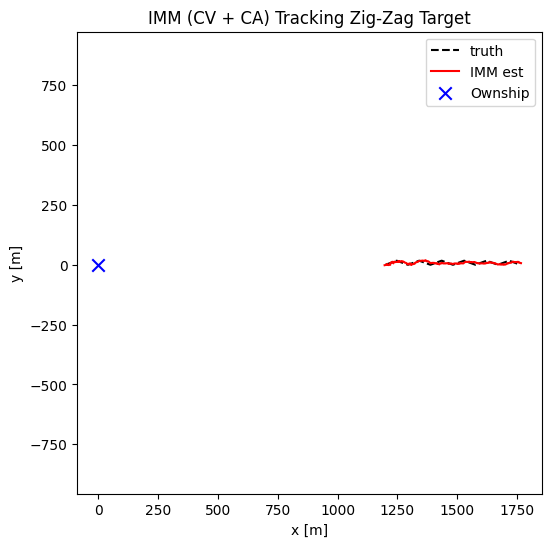

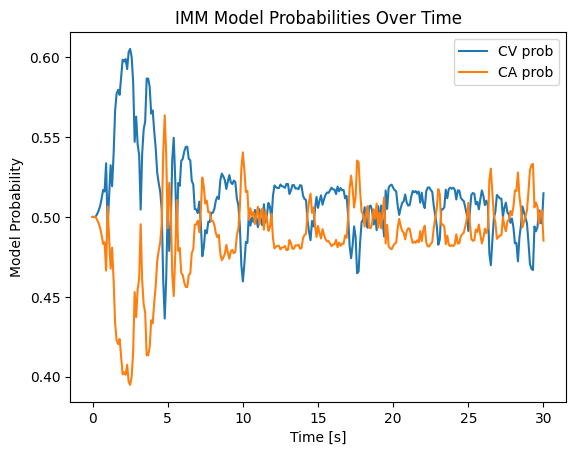

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from kf_lab.models.motion.cv import CV2D
from kf_lab.models.motion.ca import CA2D
from kf_lab.models.measurement.range_bearing import RangeBearing2D
from kf_lab.filters.ekf import EKF
from kf_lab.filters.imm import IMM
from kf_lab.sims.scenarios import zigzag_cv
from kf_lab.sensors.sampler import simulate_measurements


# =========================================================
# Simulation setup
# =========================================================
DURATION_S = 60.0
TRUTH_DT = 0.1
SENSOR_HZ = 5.0

truth, t = zigzag_cv(duration_s=DURATION_S, truth_dt=TRUTH_DT, offset_xy=(1200, 0))
rb = RangeBearing2D(xs=0.0, ys=0.0, sigma_r=5.0, sigma_b=np.deg2rad(0.5))
_, Z = simulate_measurements(truth, t, rb, sensor_hz=SENSOR_HZ)
Z = np.asarray(Z)

# =========================================================
# IMM setup: CV + CA
# =========================================================
cv = CV2D()
ca = CA2D()

x0_cv = np.array([truth[0, 0], truth[0, 1], 10.0, 0.0])
P0_cv = np.diag([100.0, 100.0, 25.0, 25.0])

x0_ca = np.array([truth[0, 0], truth[0, 1], 10.0, 0.0, 0.0, 0.0])
P0_ca = np.diag([100.0, 100.0, 25.0, 25.0, 10.0, 10.0])

ekf_cv = EKF(x0_cv, P0_cv, cv, rb)
ekf_ca = EKF(x0_ca, P0_ca, ca, rb)

PI = np.array([[0.95, 0.05],
               [0.05, 0.95]])
mu0 = np.array([0.5, 0.5])

imm = IMM([ekf_cv, ekf_ca], PI, mu0)

# =========================================================
# Run the IMM
# =========================================================
dt = 1.0 / SENSOR_HZ
X_est = []
MU_hist = []

for z in Z:
    x, P, mu = imm.step(z, dt)
    X_est.append(x.copy())
    MU_hist.append(mu.copy())

X_est = np.asarray(X_est)
MU_hist = np.asarray(MU_hist)

# =========================================================
# Plot results
# =========================================================
plt.figure(figsize=(6,6))
plt.plot(truth[:,0], truth[:,1], 'k--', label="truth")
plt.plot(X_est[:,0], X_est[:,1], 'r', label="IMM est")
plt.scatter([0], [0], c="b", marker="x", s=80, label="Ownship")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axis("equal")
plt.legend()
plt.title("IMM (CV + CA) Tracking Zig-Zag Target")
plt.show()

# Model probability over time
plt.figure()
plt.plot(t[:len(MU_hist)], MU_hist[:,0], label="CV prob")
plt.plot(t[:len(MU_hist)], MU_hist[:,1], label="CA prob")
plt.xlabel("Time [s]")
plt.ylabel("Model Probability")
plt.legend()
plt.title("IMM Model Probabilities Over Time")
plt.show()
